In [2]:
from google.colab import drive
drive.mount('/content/drive')
!sudo apt install tesseract-ocr
!pip install pytesseract

Mounted at /content/drive
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 19 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Fetched 4,850 kB in 1s (5,665 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /u

In [1]:
%cd /content/drive/MyDrive/Plate_detect_and_recognize

/content/drive/MyDrive/Plate_detect_and_recognize


In [2]:
# remove warning message
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# required library
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
from tensorflow.keras.utils import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import glob
import pytesseract

### Part 1: Extract license plate from sample image

In [3]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [4]:
wpod_net_path = r"/content/drive/MyDrive/Plate_detect_and_recognize/wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


In [5]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path, Dmax=608, Dmin = 256):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor

test_image_path = r"/content/drive/MyDrive/Upscaled picture/1677170190021-crop.jpg"
vehicle, LpImg,cor = get_plate(test_image_path)

1/1 [==============================] - 1s 775ms/step


## Part 2: Segementing license characters

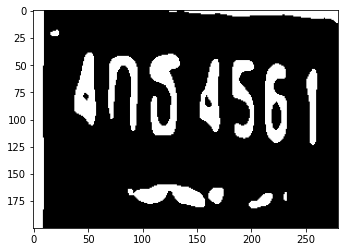

In [6]:
if (len(LpImg)): #check if there is at least one license image
    # Scales, calculates absolute values, and converts the result to 8-bit.
    plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
    
    # convert to grayscale and blur the image
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),0)
    
    # Applied inversed thresh_binary 
    binary = cv2.threshold(blur, 80, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C)[1]
    
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

plt.imshow(thre_mor ,cmap="gray")

In [7]:
extractedInformation = pytesseract.image_to_string(thre_mor, config='tessdata-dir /content/drive/MyDrive/Plate_detect_and_recognize/tessdata --psm 6 -oem 1 -c tessedit_char_whitelist=กขฆงจฉชฌญฎฐธพภวศษสฒณตถบปผยรลนฬอฮทมฟ0123456789')
print(extractedInformation)

454564



# The end!